In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm
from sympy import *

## In a (Cavendish) experiment, you have made five measurements of Earth’s density $\rho$

In [7]:
rho = np.array([5.5, 5.61, 4.88, 5.07, 5.26])
rho_error = np.array([.1, .21, .15, .14, .13])


- What is the combined result and uncertainty of these five measurements?

The combined result can be found by taking their weighted mean, either manually or using the numpy average method

Thou not required for the exercise, we can then compute the uncertainty of the weighted mean as
$$\sigma_{weighted} = \sqrt {\sum  \frac{1}{\sigma^2}}$$

Likewise we can use the Chi2 method to fit the data to a constant value, this yields the same results

In [10]:
def weighted_mean(value, error): # Manual method
    assert(len(value) == len(error))
    wmean = np.sum((value/(error**2)) / np.sum(1/(error**2)))
    wmean_err = error = np.sqrt(1/np.sum(1/np.square(error)))
    return wmean, wmean_err

solution = weighted_mean(rho, rho_error)

solution_np = np.average(rho, weights = rho_error)

error = np.sqrt(1/np.sum(1/np.square(rho_error)))
print(error)

print(solution, error, 'Manual')
print(solution_np, 'Numpy')

def mean_chi(x,a):
    return np.ones_like(x)*a

print(rho.shape)

chi2_fit = cost.LeastSquares( np.ones_like(rho), rho, rho_error, mean_chi)
chi2_fit = Minuit(chi2_fit, a = np.mean(rho))
chi2_fit.migrad()
print(chi2_fit.values['a'], chi2_fit.errors['a'], 'Chi2')




0.06005034708204228
(np.float64(5.279305828390055), np.float64(0.06005034708204228)) 0.06005034708204228 Manual
5.279041095890411 Numpy
(5,)
5.279305828381988 0.06005034706026787 Chi2


- Are your measurements consistent with each other? If not, what is then your best estimate?

To test if the data is consisten we evaluate the $\chi^2$ found previously. From this we can see that our fit only evaluates to a p value of 0.0022, meaning even at a significance level of 1% we would not be able to conclude that the measurements are consistent.
If we plot the data and the fit together with multiples of the $\chi^2$ error we can quickly spot several measurements, that are far from the fitted value. Here data point 3 looks like the biggest offender with data point 2 quickly following. In this example it is very easy to spot outliers, but this wont be the case always, we therefor evaluate all points for their distance in $\sigma$ away from the fitted mean.

P value 0.0022162034837357653


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_62869/2968357492.py:20: SyntaxWarning: invalid escape sequence '\s'
  ax.set(ylabel = '$|\sigma|$', xlabel = 'Data', ylim = (0,3))


[Text(0, 0.5, '$|\\sigma|$'), Text(0.5, 0, 'Data'), (0.0, 3.0)]

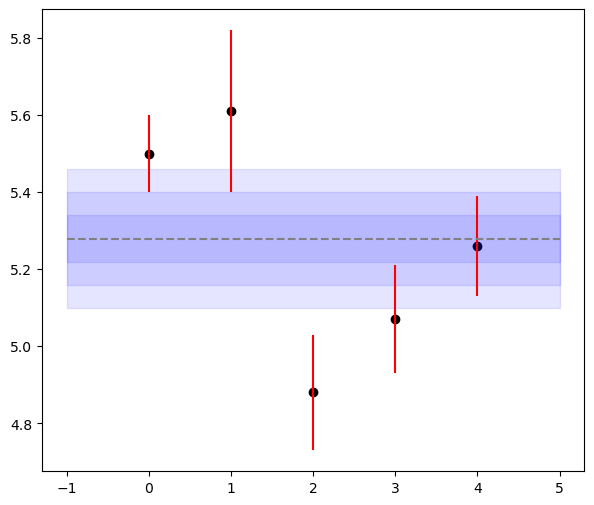

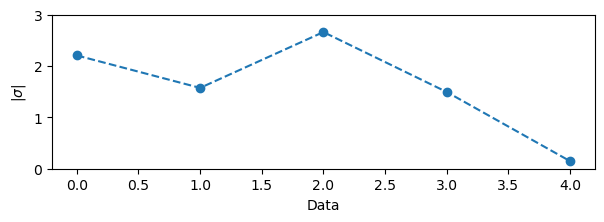

In [11]:
Chi2_val = np.sum((rho - solution[0])**2/(rho_error**2)) # Calculate the chi2 value by hand using the value obtained from the weighted mean
P_val = stats.chi2.sf(chi2_fit.fval, 4)
P_val = stats.chi2.sf(Chi2_val, 4)

print('P value', P_val)

fig, ax = plt.subplots(1,1, figsize = (7,6))
Xn = np.arange(0,len(rho),1)
ax.errorbar(Xn, rho, yerr = rho_error, ls = '', color = 'red')
ax.scatter(Xn, rho, color = 'black', label = 'Data')
ax.hlines(chi2_fit.values['a'], -1, 5, ls = '--', color = 'grey')
ax.fill_between([-1,5], chi2_fit.values['a'] - chi2_fit.errors['a'],   chi2_fit.values['a'] + chi2_fit.errors['a'], color = 'blue', alpha = .1)
ax.fill_between([-1,5], chi2_fit.values['a'] - 2*chi2_fit.errors['a'],   chi2_fit.values['a'] + 2*chi2_fit.errors['a'], color = 'blue', alpha = .1)
ax.fill_between([-1,5], chi2_fit.values['a'] - 3*chi2_fit.errors['a'],   chi2_fit.values['a'] + 3*chi2_fit.errors['a'], color = 'blue', alpha = .1)


fig, ax = plt.subplots(1,1, figsize = (7,2))
distance = np.abs(rho - chi2_fit.values['a'])/rho_error
ax.plot(Xn, distance, ls = '--', marker = 'o')
ax.set(ylabel = '$|\sigma|$', xlabel = 'Data', ylim = (0,3))



We therefor choose to discard measurement number 3, evaluate the average mean once again and compute the $\chi^2$ and associated p value. Now the P value is above 1% and for certain aplications, this would be enough. If we want to be more strict we could try to delete the next most outlying data point in order to get a higher p value. In this case I would choose not to as we then would run into a case with very few samples. When trying to evaluate data we need to find the sweetspot between enough data and data that are consistent.

In [14]:
rho_new = rho[[0,1,3,4]]
rho_error_new = rho_error[[0,1,3,4]]
solution_new = weighted_mean(rho_new, rho_error_new)
error_new = np.sqrt(1/np.sum(1/np.square(rho_error_new)))


Chi2_val = np.sum((rho_new - solution_new[0])**2/(rho_error_new**2)) # Calculate the chi2 value by hand using the value obtained from the weighted mean
P_val = stats.chi2.sf(Chi2_val, 3)

print('P value', P_val)





P value 0.041023812559931046


- The precise value is 5.514 g/cm3. How consistent is you measurement with this number?

  The agreement with the expected value can be calculated by performing a one-sample test, to calculate the
probability of obtaining the result from problem 2.2.2. This is a two-sided test, as we are only interested in
the probability of obtaining the gotten result or worse, without particular interest in whether the result lies
above or below the true value. As there are very few values (4 points), the result cannot be expected to follow
a Gaussian distribution, and a student’s t-distribution is used to obtain a probability
$$ t = \frac{\mu_{measured} - \mu_{correct}}{\sigma_{measured}}$$
To obtain a p-value from this, the student’s t-distribution survival function is used, as implemented in scipy’s
library called stats.t.sf(). The calculation has 3 degrees of freedom, as one is lost to estimating the mean. Here we get a value above the 5%, suggesting that there is agreement between the true value and the measured once. If we run the same analysis on the full set of data from the begining we get a p value below 5% agin

In [18]:
t = (solution_new[0] - 5.514)/error_new
p_val = 2*stats.t.sf(abs(t),3)
print(p_val)
t = (solution[0] - 5.514)/error
p_val = 2*stats.t.sf(abs(t),4)
print(p_val)




0.09429856557592477
0.01741897250505446
